In [1]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
# Keras NN:
from keras.utils import to_categorical
# My utils:
from codvidutils.imageproc import map_categorical
from codvidutils.cudasession import set_session
from codvidutils import nwpic as nw

Using TensorFlow backend.


In [2]:
#set_session(ngpu=1, ncpu=4)
set_session()

Num GPUs Available:  2
Num CPUs Available:  7
---------Keras session created with---------
 - 2 GPUs
 - 7 CPUs


In [3]:
train_class = pd.read_csv('data/train_split_v3.csv', sep=' ', header=1, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v3.csv', sep=' ', header=1, names=['patientID', 'image_path', 'class'])

## Preparing the categorical variable (Y)

In [4]:
values_dict = {'pneumonia': 2, 'COVID-19': 1, 'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
diseaseID = np.concatenate([diseaseID_train, diseaseID_test],axis=0)

## Reading the pictures

In [5]:
pics = []
for img in train_class['image_path'].values:
    pics.append(np.array(Image.open('data/train/' + img))[:, :,:3])
for img in test_class['image_path'].values:
    pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

print("Total number of images:", len(pics))
del train_class, test_class

Total number of images: 14982


In [6]:
X = np.array(pics)
del pics
print('shape X: {},  disease_ID (Y): {}'.format(X.shape, diseaseID.shape ))

shape X: (14982, 200, 200, 3),  disease_ID (Y): (14982,)


## Imablanced data

In [7]:
diseaseID, X = nw.underbalance_imgs(diseaseID, X)

Count of classes:  Counter({0: 8851, 2: 6034, 1: 97})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})


In [8]:
n = np.random.randint(1000,6760)
print(n)
from sklearn.utils import shuffle
X, diseaseID = shuffle(X, diseaseID, random_state=n)
from sklearn.model_selection import train_test_split
m = np.random.randint(1000,6760)
print(m)
X_train, X_test, diseaseID_train, diseaseID_test = train_test_split(X, diseaseID, test_size=0.20, random_state=m)
del X, diseaseID

5107
5560


In [9]:
X_train = X_train.reshape(X_train.shape[0],200,200,3)
X_test = X_test.reshape(X_test.shape[0],200,200,3)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))

X_train.shape: (7277, 200, 200, 3)
X_test.shape: (1820, 200, 200, 3)


In [10]:
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)

Normal train:  (3577,)
Pneumonia train:  (3618,)
COVID train:  (82,)
*******************************************************
Normal test:  (923,)
Pneumonia test:  (882,)
COVID test:  (15,)


In [11]:
"""
News images to train 
"""
X_train_news = nw.new_pictures_arrays(X_train[diseaseID_train==1])
print(X_train_news.shape)
diseaseID_train_news = np.ones(X_train_news.shape[0])
print(diseaseID_train_news.shape)
X_train = X_train[:,10:190,10:190]
X_train = np.concatenate([X_train,X_train_news],axis=0)
diseaseID_train = np.concatenate([diseaseID_train,diseaseID_train_news],axis=0)
del X_train_news, diseaseID_train_news
print(X_train.shape)
print(diseaseID_train.shape)

(2050, 180, 180, 3)
(2050,)
(9327, 180, 180, 3)
(9327,)


In [12]:
"""
News images to test 
"""
X_test_news = nw.new_pictures_arrays(X_test[diseaseID_test==1])
print(X_test_news.shape)
diseaseID_test_news = np.ones(X_test_news.shape[0])
print(diseaseID_test_news.shape)
X_test = X_test[:,10:190,10:190]
X_test = np.concatenate([X_test,X_test_news],axis=0)
diseaseID_test = np.concatenate([diseaseID_test,diseaseID_test_news],axis=0)
del X_test_news, diseaseID_test_news
print(X_test.shape)
print(diseaseID_test.shape)

(375, 180, 180, 3)
(375,)
(2195, 180, 180, 3)
(2195,)


In [13]:
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

X_test = X_test/255
X_train = X_train/255

## Neural network

In [14]:
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [26]:
input_img = Input(shape=X_train.shape[1:])
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

decoder = Conv2D(64, (3,3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(256, (3, 3), activation='relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (3, 3), activation='relu', padding='same')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0         
__________

In [27]:
best_model_path = 'Autoencoder_covid.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
amsgrad = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
autoencoder.compile(optimizer=amsgrad, loss='mse', metrics=['acc', 'mse'])
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=False, callbacks=[checkpoint],
                          validation_data=(X_test, X_test))

Train on 9152 samples, validate on 2370 samples
Epoch 1/10
9152/9152 [==============================] - 58s 6ms/step - loss: 0.0115 - acc: 0.3831 - mean_squared_error: 0.0115 - val_loss: 0.0015 - val_acc: 0.5423 - val_mean_squared_error: 0.0015

Epoch 00001: loss improved from inf to 0.01149, saving model to Autoencoder_covid.hdf5
Epoch 2/10
9152/9152 [==============================] - 55s 6ms/step - loss: 0.0013 - acc: 0.3868 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_acc: 0.5634 - val_mean_squared_error: 0.0011

Epoch 00002: loss improved from 0.01149 to 0.00127, saving model to Autoencoder_covid.hdf5
Epoch 3/10
9152/9152 [==============================] - 55s 6ms/step - loss: 0.0011 - acc: 0.3939 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_acc: 0.3744 - val_mean_squared_error: 0.0010

Epoch 00003: loss improved from 0.00127 to 0.00107, saving model to Autoencoder_covid.hdf5
Epoch 4/10
9152/9152 [==============================] - 55s 6ms/step - loss: 9.7257e-04 -

In [15]:
best_model_path = 'Autoencoder_covid.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[6].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
encoder_imgs.shape

(2195, 23, 23, 128)

Text(0.5,0,'epochs')

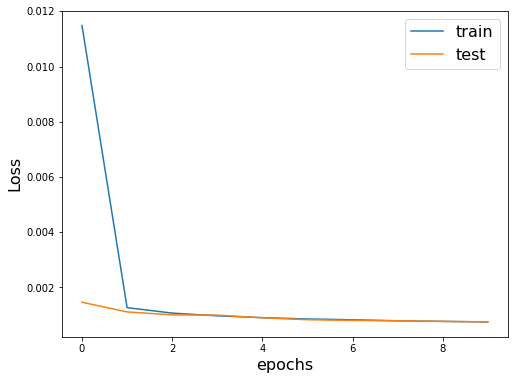

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)

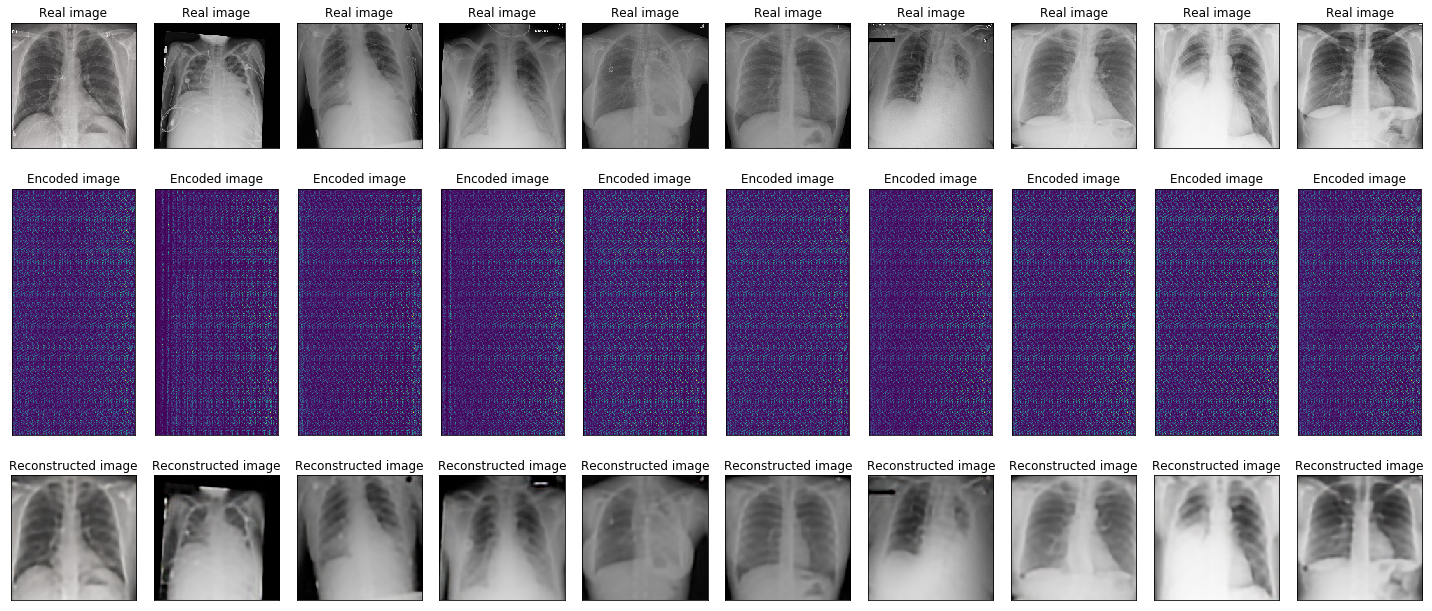

In [39]:
plt.figure(figsize=(20, 10))
for it in range(10):
    i = np.random.randint(0, len(encoder_imgs))
    ax = plt.subplot(3, 10, it+1)
    ax.imshow(X_test[i])
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Real image')
    ax2 = plt.subplot(3, 10, it + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(23*8, 23*16).T)
    plt.xticks(())
    plt.yticks(())
    ax2.set_title('Encoded image')
    ax3 = plt.subplot(3, 10, it + 1 + 2*10)
    ax3.imshow(decoder_imgs[i])
    plt.xticks(())
    plt.yticks(())
    ax3.set_title('Reconstructed image')
    plt.tight_layout()
    plt.savefig('Figures/Autoencoder_Reconstruction.png', dpi=200)

# Random Forest

In [17]:
encoder_RF_train = encoder.predict(X_train)
encoder_RF_train.shape

(9327, 23, 23, 128)

In [18]:
encoder_RF_train = encoder_RF_train.reshape((encoder_RF_train.shape[0], 23*23*128))

## Random Forest Regressor

In [20]:
RF = RandomForestRegressor(n_estimators=100, n_jobs=-1)
RF.fit(encoder_RF_train, Y_train)

KeyboardInterrupt: 

## Test

In [16]:
encoder_imgs = encoder_imgs.reshape((encoder_imgs.shape[0], 23*23*128))

In [182]:
preds = RF.predict(encoder_imgs)
nocovid = preds[np.where(Y_test == 0)]
covid = preds[np.where(Y_test == 1)]

Accuracy: 0.8877637130801688
0.9988876529477196 of 1798 no COVID-19
0.5384615384615384 of 572 COVID-19


In [ ]:
# Counting by thresholds
TP_050 = np.count_nonzero(np.where((Y_test==1) & (preds>0.50)))
FN_050 = np.count_nonzero(np.where((Y_test==1) & (preds<0.50)))
FP_050 = np.count_nonzero(np.where((Y_test==0) & (preds>0.50)))
TN_050 = np.count_nonzero(np.where((Y_test==0) & (preds<0.50)))
confusion_matrix()
cm = np.array([[TP_050, TN_050],[FN_050, FP_050]])
print("Accuracy:", accuracy_score(Y_test, preds))
print('{} of {} no COVID-19'.format(cm[0,0], np.sum(Y_test == 0)))
print('{} of {} COVID-19'.format(cm[1,1], np.sum(Y_test == 1)))

In [ ]:
cm = normalize(cm, 'l1')
labels = ['no COVID-19', 'COVID-19']
fig1, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='YlGnBu', vmin=0, vmax=1)
cbar = fig1.colorbar(cax)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_ylabel('Expected', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)

In [ ]:
fig2, ax = plt.subplots(figsize=(8,6))
ax.hist(nocovid, 50, histtype='step', lw=2, color=darkorange, label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color=darkorange, label='COVID')
plt.grid()
ax.set_ylabel('Number of events /0.01')
plt.set_xlabel('Score')
plt.legend( loc='upper center')
plt.yscale("log")

## Random forest classifier

In [ ]:
RFc = RandomForestClassifier(n_estimators=100)
preds = RFc.predict(encoder_imgs)

[[0.99888765 0.00111235]
 [0.46153846 0.53846154]]


Text(0.5,0,'Predicted')

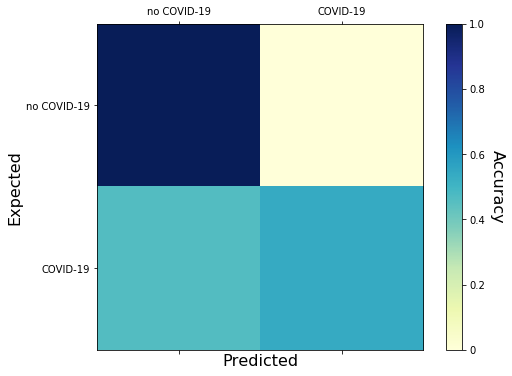

In [183]:
cm = normalize(confusion_matrix(Y_test, preds), 'l1')
print("Accuracy:", accuracy_score(Y_test, preds))
print('{} of {} no COVID-19'.format(cm[0,0], np.sum(Y_test == 0)))
print('{} of {} COVID-19'.format(cm[1,1], np.sum(Y_test == 1)))
print(cm)
cm = normalize(cm, 'l1')
labels = ['no COVID-19', 'COVID-19']
fig3, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='YlGnBu', vmin=0, vmax=1)
cbar = fig3.colorbar(cax)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_ylabel('Expected', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)